# Precision Volatility Forecasting for Strategic Quote Placement in High-Frequency Trading

In [1]:
# check python version
# automatically installs dependencies if they’re not already installed 
from install_packages import install_dependencies, check_python_version
check_python_version()
install_dependencies()


 Python version is compatible: 3.9.6
Installing missing package: arch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.6/925.6 kB 10.3 MB/s eta 0:00:00
All dependencies installed. Changes: ['arch']


In [2]:
import os
import pandas as pd
import numpy as np
import random
import importlib
import time
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

import models.util as util
importlib.reload(util)

<module 'models.util' from '/Users/dais/volatility-analysis/models/util.py'>

In [ ]:
# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [4]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)

# Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(snapshot_features_df)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df = pd.merge(
    rolling_features_df.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

# Preview
print("Rolling features:", rolling_features_df.shape)
display(rolling_features_df.head())

print("Rolling features:", snapshot_features_df.shape)
display(snapshot_features_df.head())

Rolling features: (833290, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,50200.0,6.0,1800.0,372.347747,0.152688,372.598023,372.036666,0.000037,0.000013,0.000054,...,7.589939,44.479523,395.999604,0.033333,-0.000003,0.000046,0.000159,-0.000207,0.000235,NaT
1,50200.0,6.0,1802.0,372.340905,0.156816,372.598023,371.955111,0.000038,0.000013,0.000054,...,7.582752,44.480654,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000356,NaT
2,50200.0,6.0,1805.0,372.332872,0.163290,372.598023,371.934998,0.000038,0.000013,0.000054,...,7.566621,44.482415,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000357,NaT
3,50200.0,6.0,1807.0,372.326948,0.165921,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.510483,44.485172,395.999604,0.033333,-0.000004,0.000051,0.000340,-0.000219,0.000162,NaT
4,50200.0,6.0,1810.0,372.319845,0.168082,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.508179,44.485539,395.999604,0.033333,-0.000004,0.000050,0.000340,-0.000219,0.000179,NaT


Rolling features: (4166788, 18)


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,mid_price,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,-0.000044
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,0.000000
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500,372.465,372.464998,0.01,0.000027,0.000000,1.000000,-0.000023


=== HAR-RV OLS Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00010876
QLIKE: 0.6665
Directional Accuracy: 0.5070
✅ Model saved to models/out/harrv/har_ols.pkl
HAR-RV OLS training completed in 0.59 seconds.


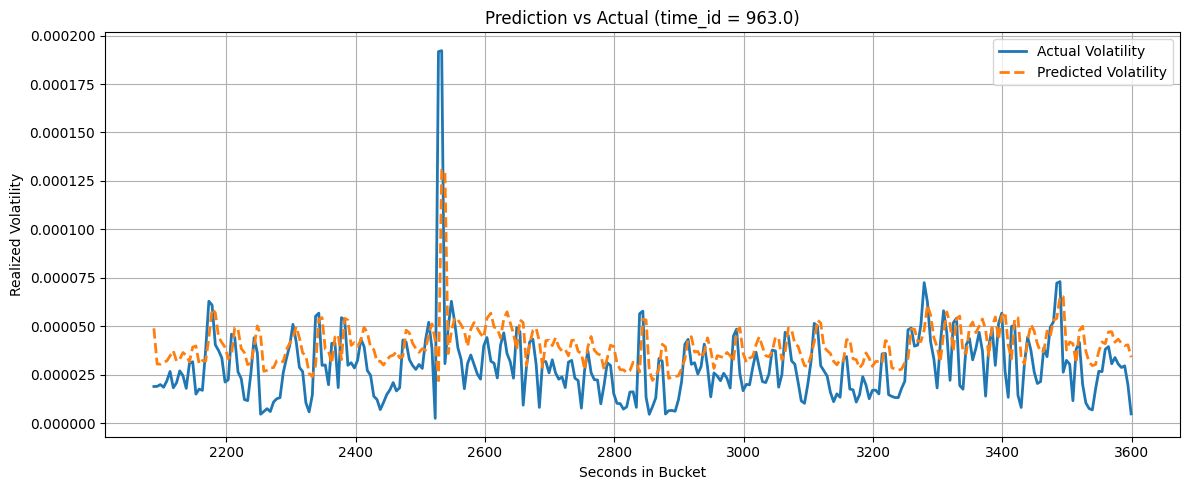

In [5]:
# Import and reload HAR-RV model
# import function from models/har_rv.py
import models.har_rv as har_rv
importlib.reload(har_rv)

# Fit HAR-RV OLS model and track computation time
start_time = time.time()
model_rv_ols, test_df_ols = har_rv.ols(rolling_features_df)
ols_time = time.time() - start_time
print(f"HAR-RV OLS training completed in {ols_time:.2f} seconds.")

# Plot predicted vs. actual volatility for one time_id
util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

=== HAR-RV WLS Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00011779
QLIKE: 0.8773
Directional Accuracy: 0.4819
✅ Model saved to models/out/harrv/har_wls.pkl
HAR-RV WLS training completed in 0.82 seconds.


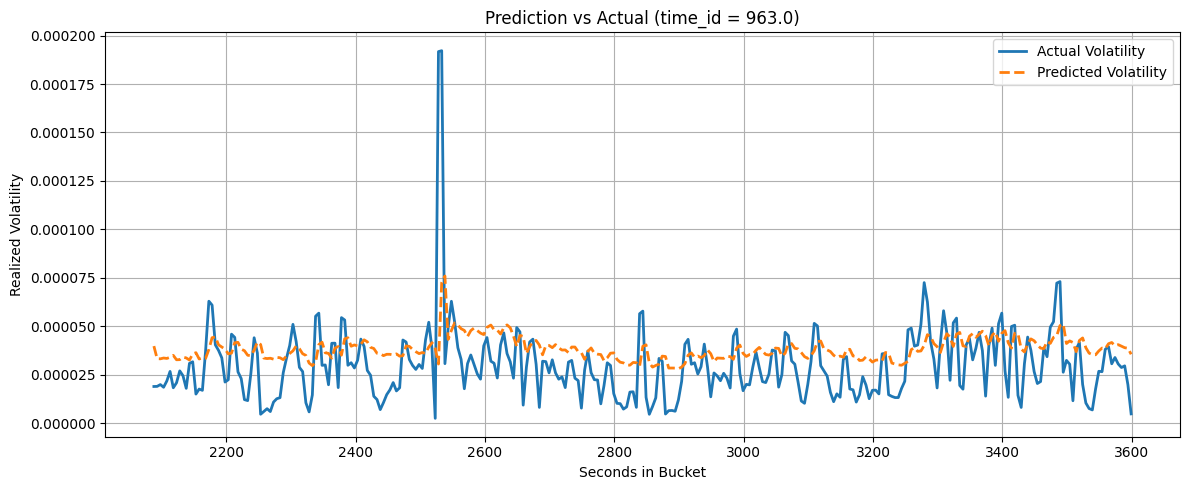

In [6]:
# Fit HAR-RV WLS model and track computation time
start_time = time.time()
model_wls, test_df_wls = har_rv.wls(rolling_features_df)
ols_time = time.time() - start_time
print(f"HAR-RV WLS training completed in {ols_time:.2f} seconds.")

# Plot predicted vs. actual volatility for one time_id
util.plot_prediction_vs_actual(
    df=test_df_wls,
    time_id=test_df_wls['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)


In [17]:
import models.lstm as lstm
importlib.reload(lstm)

subset_time_ids = snapshot_features_df['time_id'].unique()[:500]
df_subset = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()
lstm_df = util.generate_tick_sequences(df_subset, feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"])

In [18]:
importlib.reload(lstm)
model_lstm_baseline, history_lstm_baseline, test_df_lstm_baseline = lstm.baseline(lstm_df)

2025-05-13 00:11:02.180999: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-13 00:11:02.201550: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-13 00:11:02.201571: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-13 00:11:02.202440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-13 00:11:02.203317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-05-13 00:11:10.428008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8152/8152 ━━━━━━━━━━━━━━━━━━━━ 239s 29ms/step - loss: 0.5145 - val_loss: 0.2744 - learning_rate: 1.0000e-04
Epoch 2/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 236s 29ms/step - loss: 0.3741 - val_loss: 0.2344 - learning_rate: 1.0000e-04
Epoch 3/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 237s 29ms/step - loss: 0.3769 - val_loss: 0.2335 - learning_rate: 1.0000e-04
Epoch 4/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 238s 29ms/step - loss: 0.3671 - val_loss: 0.2058 - learning_rate: 1.0000e-04
Epoch 5/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 238s 29ms/step - loss: 0.3660 - val_loss: 0.1930 - learning_rate: 1.0000e-04
Epoch 6/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 239s 29ms/step - loss: 0.3629 - val_loss: 0.1918 - learning_rate: 1.0000e-04
Epoch 7/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 239s 29ms/step - loss: 0.3645 - val_loss: 0.1939 - learning_rate: 1.0000e-04
Epoch 8/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 239s 29ms/step - loss: 0.3687 - val_loss: 0.1795 - learning_rate: 1.0000e-04
Epoch 9/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 239s 29ms/step - 

=== Final Evaluation ===
MSE: 0.00000000
RMSE: 0.00003617
QLIKE: 0.3992
Directional Accuracy: 0.3501
✅ Model saved to models/out/lstm/lstm_baseline.h5
✅ Scalers saved to models/out/lstm/lstm_baseline_scalers.pkl


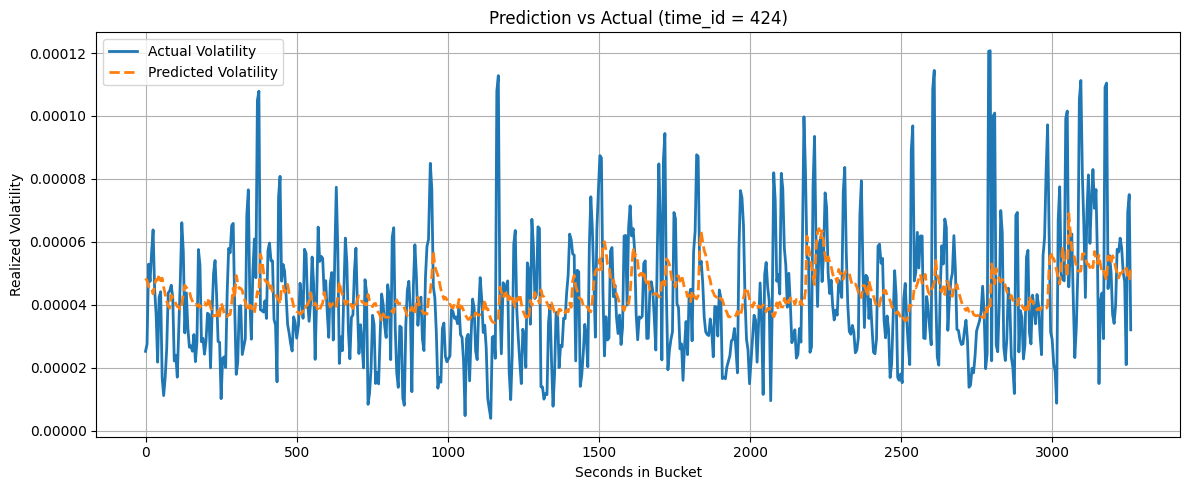

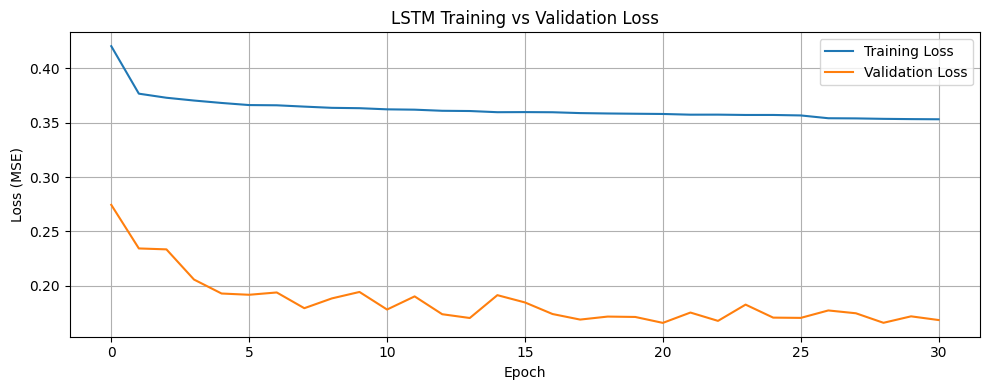

In [19]:
#test_df_lstm['time_id'].iloc[1]

util.plot_prediction_vs_actual(
    df=test_df_lstm_baseline,
    time_id=test_df_lstm_baseline['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_baseline)

In [20]:
model_lstm_v256d03, history_lstm_v256d03, test_df_lstm_v256d03 = lstm.config_v256d03(lstm_df)

Epoch 1/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 2294s 281ms/step - loss: 0.4450 - val_loss: 0.2723 - learning_rate: 1.0000e-04
Epoch 2/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 335s 41ms/step - loss: 0.3812 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 3/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 2381s 292ms/step - loss: 0.3658 - val_loss: 0.3033 - learning_rate: 1.0000e-04
Epoch 4/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 332s 41ms/step - loss: 0.3780 - val_loss: 0.2473 - learning_rate: 1.0000e-04
Epoch 5/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 334s 41ms/step - loss: 0.3680 - val_loss: 0.2013 - learning_rate: 1.0000e-04
Epoch 6/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 3861s 474ms/step - loss: 0.3686 - val_loss: 0.2055 - learning_rate: 1.0000e-04
Epoch 7/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 5015s 615ms/step - loss: 0.3620 - val_loss: 0.1987 - learning_rate: 1.0000e-04
Epoch 8/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 1167s 143ms/step - loss: 0.3610 - val_loss: 0.2132 - learning_rate: 1.0000e-04
Epoch 9/50
8152/8152 ━━━━━━━━━━━━━━━━━

=== Final Evaluation ===
MSE: 0.00000000
RMSE: 0.00003588
QLIKE: 0.3884
Directional Accuracy: 0.3830
✅ Model saved to models/out/lstm/config_v256d03.h5
✅ Scalers saved to models/out/lstm/config_v256d03_scalers.pkl


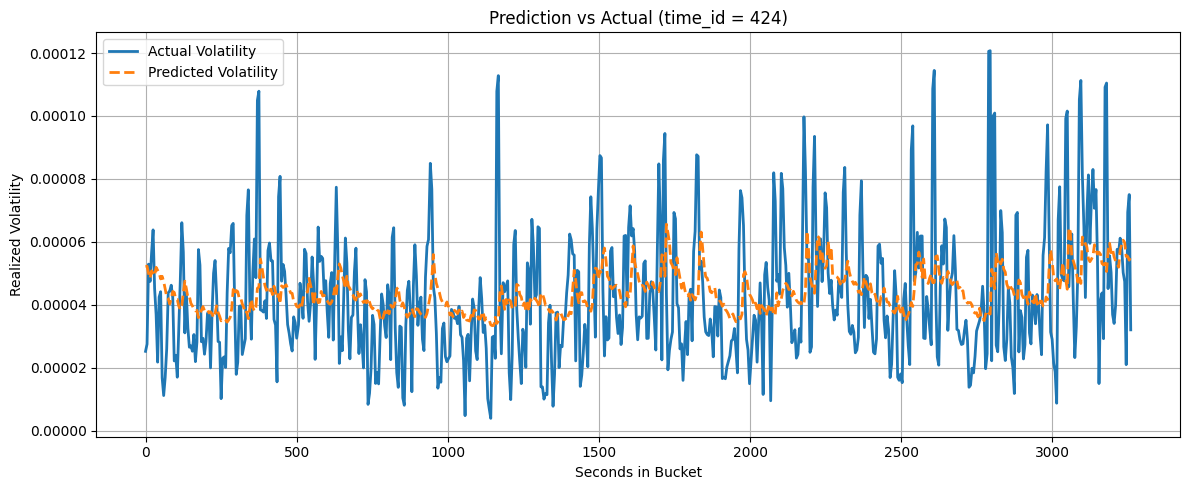

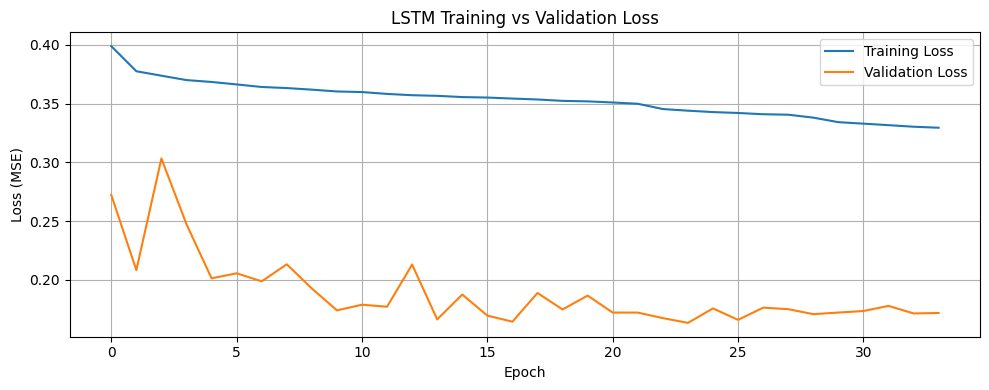

In [21]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_v256d03,
    time_id=test_df_lstm_v256d03['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_v256d03)

In [22]:
snapshot_more_feature_df = util.add_features(snapshot_features_df)
feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]


subset_time_ids = snapshot_more_feature_df['time_id'].unique()[:500]
df_subset = snapshot_more_feature_df[snapshot_more_feature_df['time_id'].isin(subset_time_ids)].copy()
lstm_df_more_feature = util.generate_tick_sequences(df_subset, feature_cols)

In [23]:
model_lstm_more_feature, history_lstm_more_feature, test_df_lstm_more_feature = lstm.config_v256d03_more_feature(lstm_df_more_feature)

Epoch 1/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 373s 45ms/step - loss: 0.4063 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 2/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 1700s 209ms/step - loss: 0.3747 - val_loss: 0.2140 - learning_rate: 1.0000e-04
Epoch 3/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 605s 74ms/step - loss: 0.3673 - val_loss: 0.1962 - learning_rate: 1.0000e-04
Epoch 4/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 1478s 181ms/step - loss: 0.3685 - val_loss: 0.1777 - learning_rate: 1.0000e-04
Epoch 5/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 361s 44ms/step - loss: 0.3706 - val_loss: 0.1681 - learning_rate: 1.0000e-04
Epoch 6/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 2342s 287ms/step - loss: 0.3629 - val_loss: 0.1861 - learning_rate: 1.0000e-04
Epoch 7/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 363s 44ms/step - loss: 0.3608 - val_loss: 0.1816 - learning_rate: 1.0000e-04
Epoch 8/50
8152/8152 ━━━━━━━━━━━━━━━━━━━━ 2313s 284ms/step - loss: 0.3533 - val_loss: 0.1937 - learning_rate: 1.0000e-04
Epoch 9/50
8152/8152 ━━━━━━━━━━━━━━━━━━━

=== Final Evaluation ===
MSE: 0.00000000
RMSE: 0.00003597
QLIKE: 0.3805
Directional Accuracy: 0.3806
✅ Model saved to models/out/lstm/config_v256d03_more_feature.h5
✅ Scalers saved to models/out/lstm/config_v256d03_more_feature_scalers.pkl


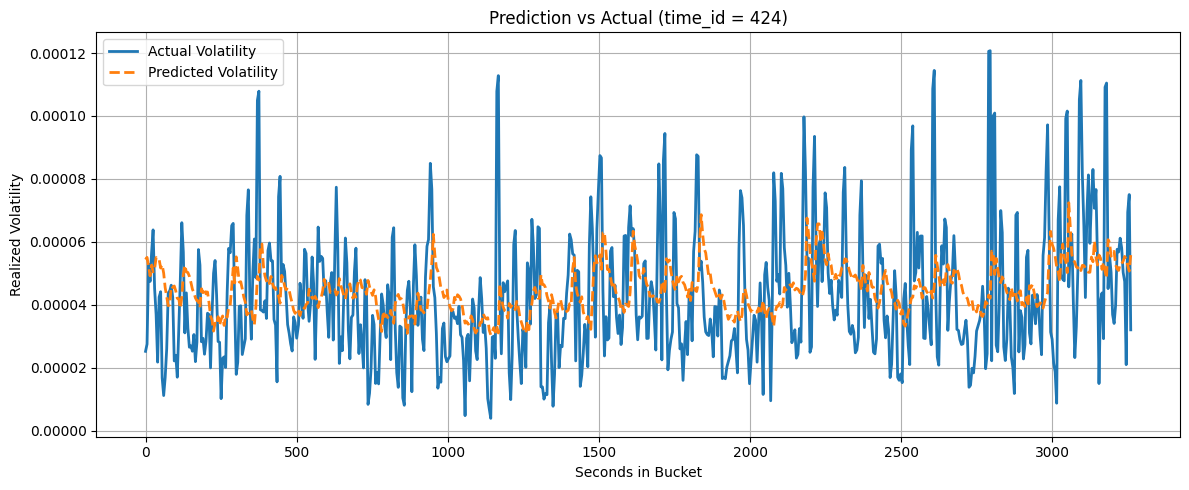

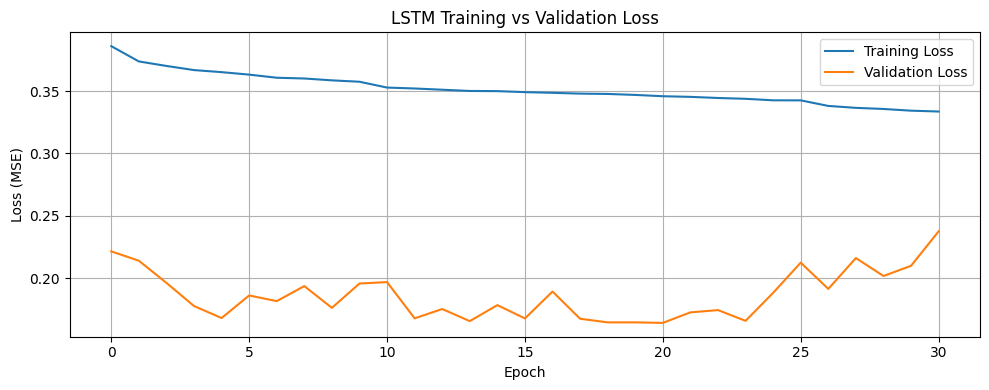

In [24]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_more_feature,
    time_id=test_df_lstm_more_feature['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_more_feature)

In [8]:
import models.garch as garch
importlib.reload(garch)

selected_ids = rolling_features_df["time_id"].drop_duplicates().sort_values().iloc[:500]

rolling_subset = rolling_features_df[rolling_features_df["time_id"].isin(selected_ids)].reset_index(drop=True)
snapshot_subset = snapshot_features_df[snapshot_features_df["time_id"].isin(selected_ids)].reset_index(drop=True)

print(rolling_subset.keys())
print(snapshot_subset.keys())

Index(['stock_id', 'time_id', 'start_time', 'wap_mean', 'wap_std', 'wap_max',
       'wap_min', 'spread_pct_mean', 'spread_pct_std', 'spread_pct_max',
       'spread_pct_min', 'imbalance_mean', 'imbalance_std', 'imbalance_max',
       'imbalance_min', 'depth_ratio_mean', 'depth_ratio_std',
       'depth_ratio_max', 'depth_ratio_min', 'log_return_mean',
       'log_return_std', 'log_return_max', 'log_return_min',
       'realized_volatility', 'datetime'],
      dtype='object')
Index(['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2', 'mid_price', 'wap', 'bid_ask_spread', 'spread_pct',
       'imbalance', 'depth_ratio', 'log_return'],
      dtype='object')


In [9]:
importlib.reload(garch)

start = time.time()
model, result_df = garch.baseline(rolling_subset, snapshot_subset)
elapsed = time.time() - start

print(f"GARCH Baseline computation time: {elapsed:.2f} seconds")

Running ARMA-GARCH forecast...


Processing:  53%|█████▎    | 38238/71978 [12:40<05:47, 97.16it/s] /Users/dais/volatility-analysis/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/dais/volatility-analysis/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing:  53%|█████▎    | 38252/71978 [12:41<10:50, 51.83it/s]/Users/dais/volatility-analysis/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing:  97%|█████████▋| 69757/71978 [22

=== ARMA-GARCH Baseline Evaluation (on test set) ===
MSE: 604938778390050111488.00000000
RMSE: 24595503214.81652832
QLIKE: 1.3900
Directional Accuracy: 0.4979
Success Rate: 65395/71978
✅ GARCH model saved to models/out/garch/baseline.pkl
GARCH Baseline computation time: 1414.08 seconds


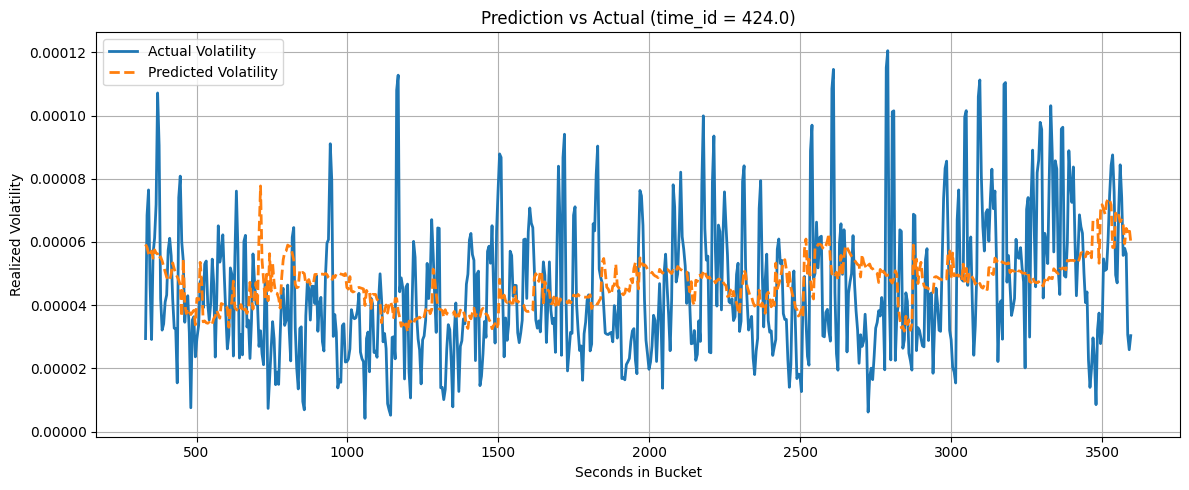

In [27]:
util.plot_prediction_vs_actual(
    df=result_df,
    time_id=result_df['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

In [ ]:
importlib.reload(garch)
# running a grid search over GARCH(p, q) models to find the best combination of p and q that minimizes error
model_garch_grid, result_df_garch_grid = garch.baseline_grid(
    rolling_df=rolling_subset,
    full_df=snapshot_subset,
    p_values=[1, 2, 3], 
    q_values=[1, 2, 3],
    scale=1000000
)

🔍 Grid search over (p, q) combinations: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]

▶ Evaluating GARCH(1,1)


GARCH(1,1):  53%|█████▎    | 38221/71978 [04:55<01:59, 282.85it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,1):  53%|█████▎    | 38251/71978 [04:55<03:16, 171.56it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,1)

    → RMSE = 24595503214.81652832, QLIKE = 1.3900, Directional Accuracy = 0.4979

▶ Evaluating GARCH(1,2)


GARCH(1,2):  53%|█████▎    | 38225/71978 [06:38<02:13, 253.32it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,2):  68%|██████▊   | 48604/71978 [08:27<04:38, 84.01it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,2)

    → RMSE = 0.00010116, QLIKE = 1.3699, Directional Accuracy = 0.4998

▶ Evaluating GARCH(1,3)


GARCH(1,3):   2%|▏         | 1740/71978 [00:21<14:48, 79.06it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,3):  25%|██▍       | 17651/71978 [03:49<12:26, 72.77it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,3):  26%|██▌       | 18566/71978 [04:01<13:03, 68.19it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(1,3):  5

    → RMSE = 0.00010123, QLIKE = 1.3578, Directional Accuracy = 0.5000

▶ Evaluating GARCH(2,1)


GARCH(2,1):  53%|█████▎    | 38222/71978 [06:11<02:06, 266.71it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,1):  53%|█████▎    | 38250/71978 [06:11<03:58, 141.23it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,1)

    → RMSE = 0.00010127, QLIKE = 1.4292, Directional Accuracy = 0.4984

▶ Evaluating GARCH(2,2)


GARCH(2,2):  39%|███▉      | 28027/71978 [06:05<09:49, 74.61it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,2):  48%|████▊     | 34801/71978 [07:34<08:02, 77.03it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,2):  53%|█████▎    | 38225/71978 [08:19<02:28, 227.76it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fm

    → RMSE = 1568719838.41345263, QLIKE = 1.4135, Directional Accuracy = 0.4997

▶ Evaluating GARCH(2,3)


GARCH(2,3):  14%|█▎        | 9734/71978 [02:29<17:59, 57.68it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,3):  25%|██▍       | 17655/71978 [04:36<14:41, 61.63it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,3):  26%|██▌       | 18558/71978 [04:50<16:23, 54.31it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,3):  2

    → RMSE = 0.00010130, QLIKE = 1.4159, Directional Accuracy = 0.5001

▶ Evaluating GARCH(3,1)


GARCH(3,1):  53%|█████▎    | 38223/71978 [07:30<02:21, 238.28it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,1):  53%|█████▎    | 38248/71978 [07:30<04:50, 116.16it/s]/Users/kan

    → RMSE = 0.00010134, QLIKE = 1.4234, Directional Accuracy = 0.5009

▶ Evaluating GARCH(3,2)


GARCH(3,2):  13%|█▎        | 9338/71978 [02:20<18:44, 55.71it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,2):  18%|█▊        | 12636/71978 [03:10<16:27, 60.08it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,2):  18%|█▊        | 12954/71978 [03:15<18:51, 52.17it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warning

    → RMSE = 0.00010145, QLIKE = 1.4582, Directional Accuracy = 0.5010

▶ Evaluating GARCH(3,3)


GARCH(3,3):   4%|▍         | 3219/71978 [00:58<21:11, 54.08it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,3):  13%|█▎        | 9479/71978 [02:51<15:32, 67.05it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,3):  18%|█▊        | 12634/71978 [03:50<18:54, 52.30it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for c

    → RMSE = 0.00010146, QLIKE = 1.4788, Directional Accuracy = 0.5012

✅ Grid Search Complete. Best Model Summary:
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -1739.18
Distribution:                  Normal   AIC:                           3490.37
Method:            Maximum Likelihood   BIC:                           3513.14
                                        No. Observations:                  329
Date:                Tue, May 13 2025   Df Residuals:                      327
Time:                        18:43:28   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------

AttributeError: 'ARX' object has no attribute 'p'

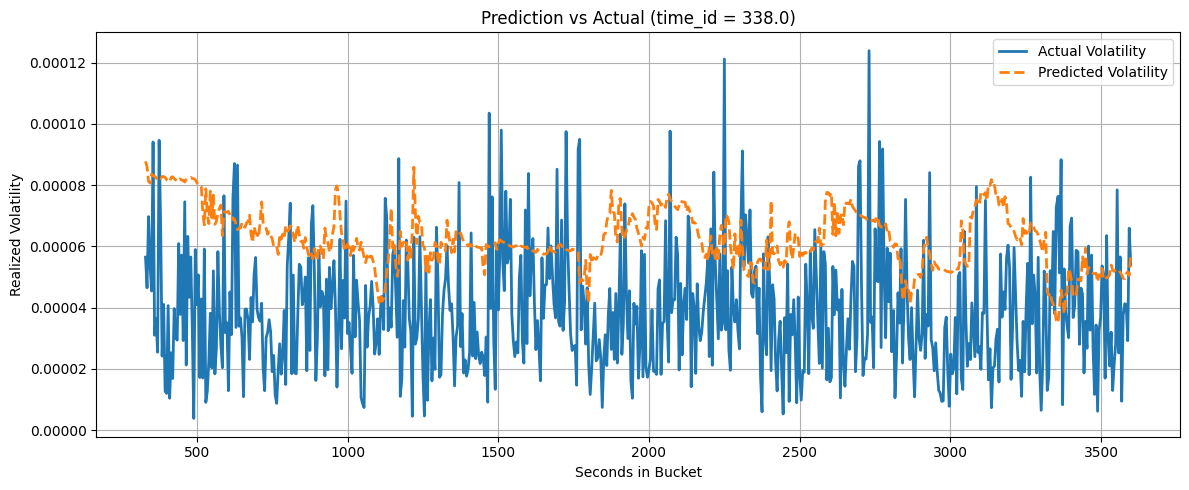

In [ ]:
util.plot_prediction_vs_actual(
    df=result_df_garch_grid,
    time_id=result_df_garch_grid['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)